### Data Mid-bootcamp project classification

In [102]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

### 0. Project details

***Goal: build a model that will provide insight into why some bank customers accept credit card offers***

**Definitions:**
- Customer Number: A sequential number assigned to the customers (this column is hidden and excluded – this unique identifier will not be used directly).
- Offer Accepted (**target variable**): Did the customer accept (Yes) or reject (No) the offer. Reward: The type of reward program offered for the card.
- Mailer Type: Letter or postcard.
- Income Level: Low, Medium or High.
- #Bank Accounts Open: How many non-credit-card accounts are held by the customer.
- Overdraft Protection: Does the customer have overdraft protection on their checking account(s) (Yes or No).
- Credit Rating: Low, Medium or High.
- #Credit Cards Held: The number of credit cards held at the bank.
- #Homes Owned: The number of homes owned by the customer.
- Household Size: Number of individuals in the family.
- Own Your Home: Does the customer own their home? (Yes or No).
- Average Balance: Average account balance (across all accounts over time). Q1, Q2, Q3 and Q4
- Balance: Average balance for each quarter in the last year

### 1. Getting data
- Read the `.csv` file.

In [2]:
data = pd.read_csv('data/creditcardmarketing_copy.csv')
data.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


### 2. Cleaning/Wrangling/EDA

- Rename columns with the PEP 8 (snake case)
- Check: info, shape, descriptive statistics, NaN, duplicated and blank values
    

In [3]:
data.columns = data.columns.str.replace(' ', '_').str.lower()
data.columns

Index(['customer_number', 'offer_accepted', 'reward', 'mailer_type',
       'income_level', '#_bank_accounts_open', 'overdraft_protection',
       'credit_rating', '#_credit_cards_held', '#_homes_owned',
       'household_size', 'own_your_home', 'average_balance', 'q1_balance',
       'q2_balance', 'q3_balance', 'q4_balance'],
      dtype='object')

In [4]:
print(data.shape)
print('------------')
data.isna().sum()/len(data)

(18000, 17)
------------


customer_number         0.000000
offer_accepted          0.000000
reward                  0.000000
mailer_type             0.000000
income_level            0.000000
#_bank_accounts_open    0.000000
overdraft_protection    0.000000
credit_rating           0.000000
#_credit_cards_held     0.000000
#_homes_owned           0.000000
household_size          0.000000
own_your_home           0.000000
average_balance         0.001333
q1_balance              0.001333
q2_balance              0.001333
q3_balance              0.001333
q4_balance              0.001333
dtype: float64

In [5]:
# It is observed that there are 5 columns with 24 null values, which represents less than 0.5%

In [6]:
data = data.dropna()
data.shape

(17976, 17)

In [7]:
# Nulls are removed because they are too few.

In [8]:
data.duplicated().sum()

0

In [9]:
# There are no duplicated values.

In [10]:
#The count of values are calculated, except for those columns with many unique values.
for x in data.columns:
    if not x in ['customer_number','average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance']:
        print(x)
        print(data[x].value_counts())
        print('------')

offer_accepted
No     16955
Yes     1021
Name: offer_accepted, dtype: int64
------
reward
Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64
------
mailer_type
Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64
------
income_level
Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64
------
#_bank_accounts_open
1    13674
2     4007
3      295
Name: #_bank_accounts_open, dtype: int64
------
overdraft_protection
No     15300
Yes     2676
Name: overdraft_protection, dtype: int64
------
credit_rating
High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64
------
#_credit_cards_held
2    7933
1    6147
3    3381
4     515
Name: #_credit_cards_held, dtype: int64
------
#_homes_owned
1    14502
2     3289
3      185
Name: #_homes_owned, dtype: int64
------
household_size
3    5705
4    5532
5    2851
2    2809
1     539
6     538
8       1
9       1
Name: household_size, dtype: int64
------
own_your_h

In [11]:
# In some columns such as offer_accepted a data imbalance is observed that will be analyzed later.

In [12]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_number,17976.0,8999.727192,5196.958865,1.00,4498.75,9000.5,13501.25,18000.00
#_bank_accounts_open,17976.0,1.255730,0.472405,1.00,1.00,1.0,1.00,3.00
#_credit_cards_held,17976.0,1.903427,0.797086,1.00,1.00,2.0,2.00,4.00
#_homes_owned,17976.0,1.203549,0.427446,1.00,1.00,1.0,1.00,3.00
household_size,17976.0,3.499110,1.114476,1.00,3.00,3.0,4.00,9.00
average_balance,17976.0,940.515562,350.297837,48.25,787.50,1007.0,1153.25,3366.25
q1_balance,17976.0,910.450656,620.077060,0.00,392.75,772.0,1521.00,3450.00
q2_balance,17976.0,999.392190,457.402268,0.00,663.00,1032.0,1342.00,3421.00
q3_balance,17976.0,1042.033600,553.452599,0.00,633.00,945.5,1463.00,3823.00
q4_balance,17976.0,810.185803,559.001365,0.00,363.00,703.0,1212.00,4215.00


- For the columns from average_balance hereinafter, the data is observed to be very far from the mean, according to its standard deviation.
- Also, they have a bias to the left.
- The average balance of all customers is 940. 
- As the year goes by, this average increases, with the exception of the last quarter (q4) which decreases.

#### 2.1 Numerical columns and its plots.

In [13]:
num_df = data.select_dtypes('number')
num_df

,customer_number,#_bank_accounts_open,#_credit_cards_held,#_homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,1,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
1,2,1,2,2,5,147.25,39.0,106.0,78.0,366.0
2,3,2,2,1,2,276.50,367.0,352.0,145.0,242.0
3,4,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
4,5,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0
...,...,...,...,...,...,...,...,...,...,...
17995,17996,1,1,1,5,167.50,136.0,65.0,71.0,398.0
17996,17997,1,3,1,3,850.50,984.0,940.0,943.0,535.0
17997,17998,1,2,1,4,1087.25,918.0,767.0,1170.0,1494.0
17998,17999,1,4,2,2,1022.25,626.0,983.0,865.0,1615.0


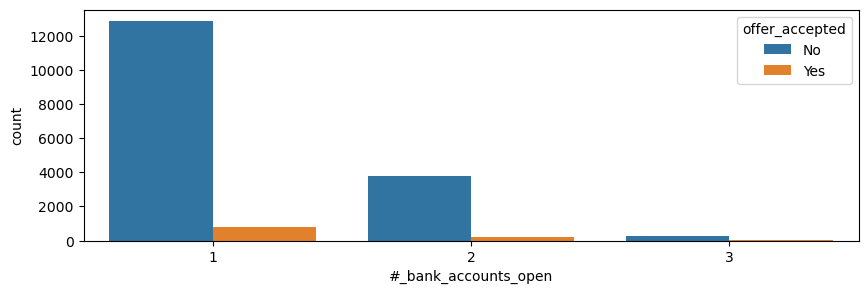

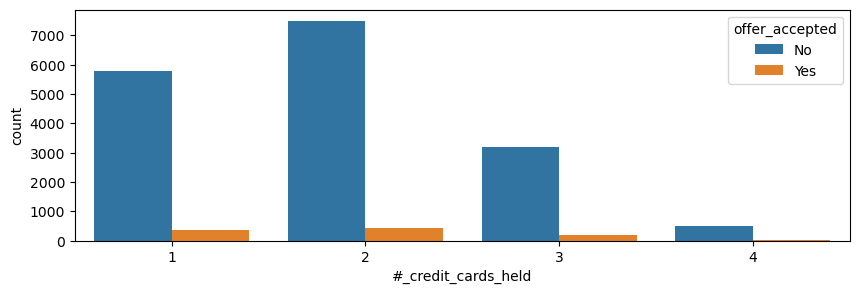

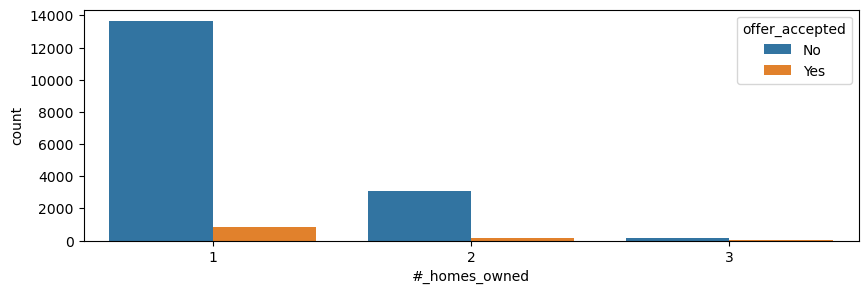

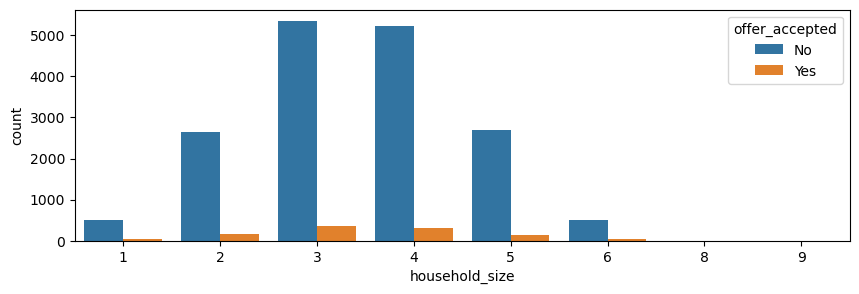

In [14]:
# A countplot is used for discrete variables

for column in num_df.columns[0:5]:
    if not column in ['customer_number']:
        plt.figure(figsize=(10,3))
        sns.countplot(data=data, x=num_df[column], hue=data['offer_accepted'])
        plt.show()

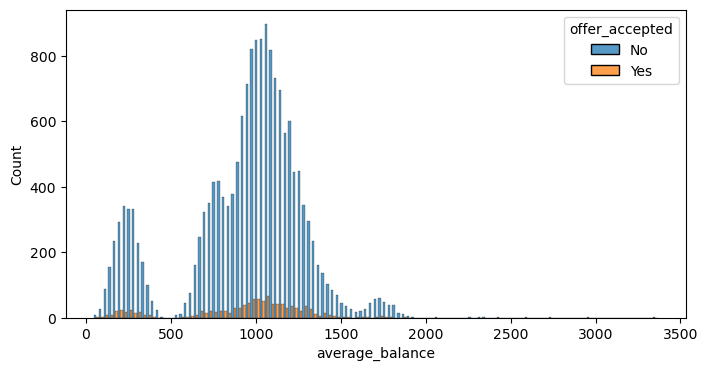

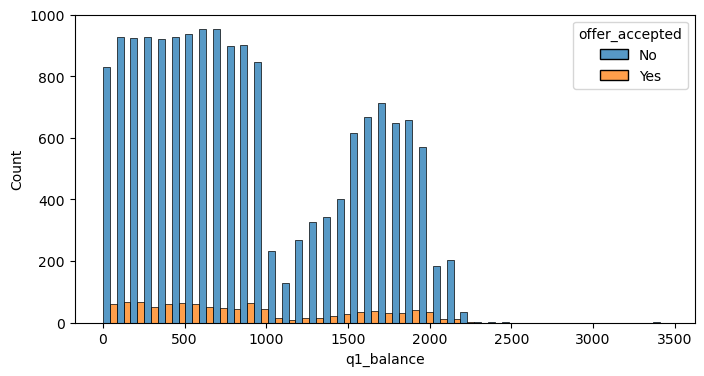

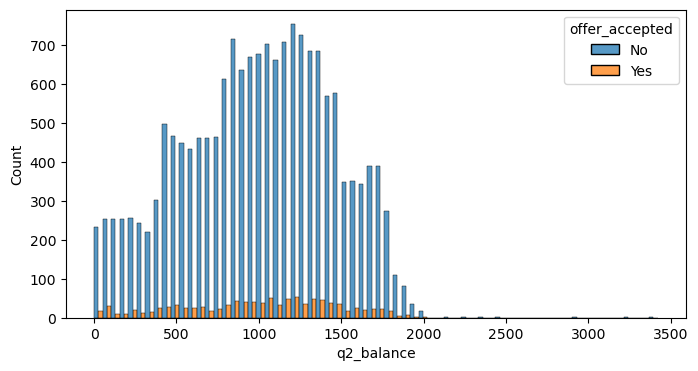

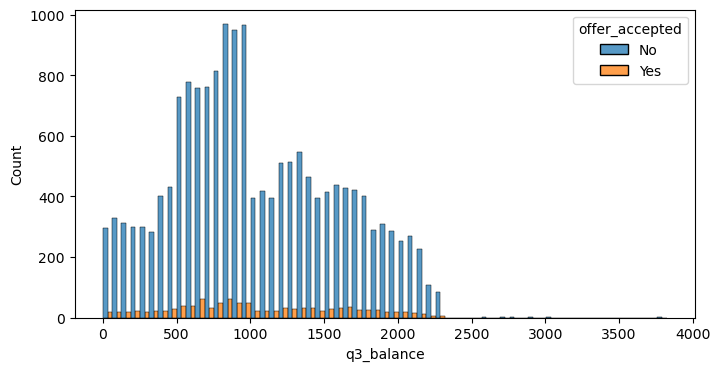

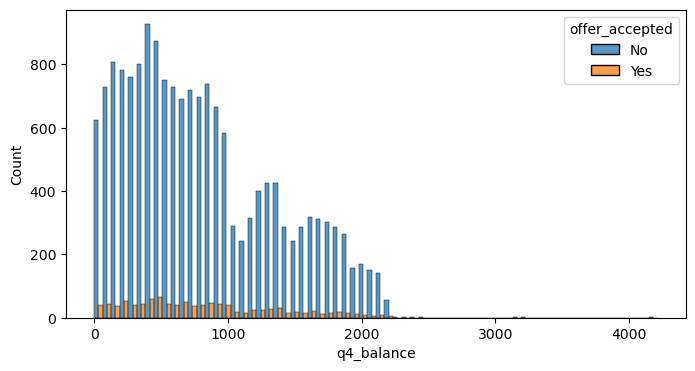

In [15]:
for column in num_df.columns[5:10]:
    plt.figure(figsize=(8,4))
    sns.histplot(data=data, x=column, hue='offer_accepted', multiple='dodge')
    plt.show()

#### 2.2 Categorical columns and its plots.

In [95]:
cat_df = data.select_dtypes('object')
cat_df.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,No,Air Miles,Letter,High,No,High,No
1,No,Air Miles,Letter,Medium,No,Medium,Yes
2,No,Air Miles,Postcard,High,No,Medium,Yes
3,No,Air Miles,Letter,Medium,No,High,No
4,No,Air Miles,Letter,Medium,No,Medium,Yes


In [96]:
for column in cat_df.columns:
     if column in ['offer_accepted', 'mailer_type','overdraft_protection', 'own_your_home']:
        enc = preprocessing.OneHotEncoder(drop='first', sparse_output=False)
        cat_df[column] = enc.fit_transform(cat_df[[column]])
        cat_df[column] = pd.DataFrame(cat_df[column])

In [97]:
cat_df.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,0.0,Air Miles,0.0,High,0.0,High,0.0
1,0.0,Air Miles,0.0,Medium,0.0,Medium,1.0
2,0.0,Air Miles,1.0,High,0.0,Medium,1.0
3,0.0,Air Miles,0.0,Medium,0.0,High,0.0
4,0.0,Air Miles,0.0,Medium,0.0,Medium,1.0


In [98]:
dummies_encoder = pd.get_dummies(cat_df, drop_first=True, columns=['reward'])

In [99]:
dummies_encoder

,offer_accepted,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home,reward_Cash Back,reward_Points
0,0.0,0.0,High,0.0,High,0.0,0,0
1,0.0,0.0,Medium,0.0,Medium,1.0,0,0
2,0.0,1.0,High,0.0,Medium,1.0,0,0
3,0.0,0.0,Medium,0.0,High,0.0,0,0
4,0.0,0.0,Medium,0.0,Medium,1.0,0,0
...,...,...,...,...,...,...,...,...
17995,0.0,0.0,High,0.0,Low,1.0,1,0
17996,0.0,0.0,High,0.0,Low,1.0,1,0
17997,0.0,0.0,High,0.0,Low,0.0,1,0
17998,0.0,0.0,Medium,0.0,Medium,1.0,1,0


In [105]:
ordinal = preprocessing.OrdinalEncoder()
cat_df[["income_level"]] = enc.fit_transform(cat_df[["income_level"]])

ValueError: Columns must be same length as key

In [ ]:
enc = pd.get_dummies(df_cat, drop_first=True)


### 3. Processing Data

In [ ]:
for column in num_df.columns[5:10]:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=data, x=column, y='offer_accepted')
    plt.show()